# Дашборд для Яндекс.Дзен

**Бизнес-задача:**  

- анализ взаимодействия пользователей с карточками Яндекс.Дзен;

**Насколько часто предполагается пользоваться дашбордом:**  

- не реже, чем раз в неделю;  

**Кто будет основным пользователем дашборда:** 

- менеджеры по анализу контента;  
**Состав данных для дашборда:**  
- История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);  
- Разбивка событий по темам источников;  
- Таблица соответствия тем источников темам карточек;  
**По каким параметрам данные должны группироваться:**  
- Дата и время;  
- Тема карточки;  
- Тема источника;  
- Возрастная группа;  
**Характер данных:**. 
- История событий по темам карточек — абсолютные величины с разбивкой по минутам;  
- Разбивка событий по темам источников — относительные величины (% событий);  
- Соответствия тем источников темам карточек - абсолютные величины;  
**Важность:** все графики имеют равную важность;  
**Источники данных для дашборда:**   cырые данные о событиях взаимодействия пользователей с карточками (таблица `log_raw`);  
**База данных, в которой будут храниться агрегированные данные:** дополнительные агрегированные таблицы в БД `zen`;  
**Частота обновления данных:** один раз в сутки, в полночь по `UTC`;  
**Какие графики должны отображаться и в каком порядке, какие элементы управления должны быть на дашборде (макет дашборда):**

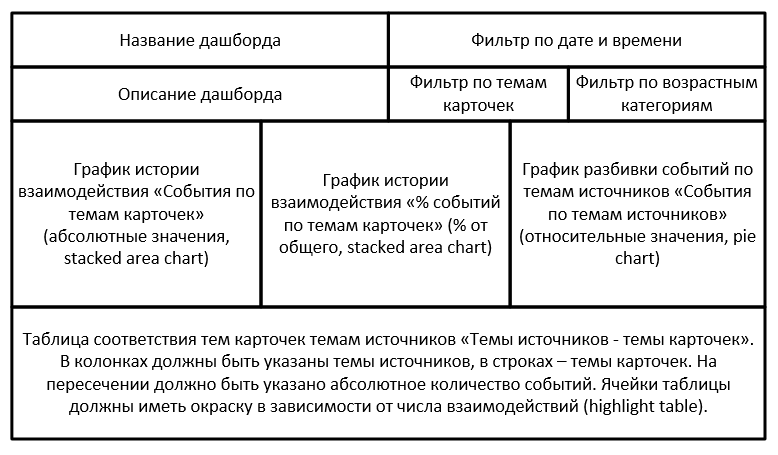

[Dashboard](https://public.tableau.com/app/profile/artykrafty/viz/Draft_16387296273360/Dashboard1) и [презентация](https://drive.google.com/file/d/116t3rvdohOtae0pT4J875kiUHnoyv3BF/view?usp=sharing)

Импортируем необходимые библиотеки и подключимся к БД

In [4]:
import sys
import getopt
import warnings
from datetime import datetime
import pandas as pd
from sqlalchemy import create_engine
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('chained_assignment', None)

In [5]:
db_config = {'user': 'praktikum_student', 
            'pwd': 'Sdf4$2;d-d30pp', 
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, 
            'db': 'data-analyst-zen-project-db'} 


connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string) 

In [6]:
def select_sql(sql):
    return pd.io.sql.read_sql(sql, con = engine)

Сначала посмотрим сырые данные - это поможет составить в будущем `pipeline` закгрузки данных

In [7]:
sql = '''select * from log_raw
limit 5'''

In [8]:
select_sql(sql)

,event_id,age_segment,event,item_id,item_topic,item_type,source_id,source_topic,source_type,ts,user_id
0,2931262,18-25,show,1793260,Красота,native,8388799,История,publisher,1569349657638,2185026
1,2931277,18-25,show,7465641,Культура,native,5837959,История,publisher,1569349657971,6845238
2,2931285,18-25,show,406073,История,url,2335872,Сад и дача,domain,1569349658408,5244363
3,2931247,26-30,show,752665,Путешествия,native,6963489,Здоровье,publisher,1569349657189,7553074
4,2931278,26-30,click,6843081,Юмор,url,5427748,Семейные отношения,domain,1569349658054,1317585


In [9]:
sql = '''select count(*) from log_raw'''

In [10]:
select_sql(sql)

,count
0,322391


Столбец ts необходимо будет перевести к UTC времени

In [11]:
sql = '''select *, TO_TIMESTAMP(ts / 1000) AT TIME ZONE 'Etc/UTC' as dt from log_raw'''

In [12]:
log_raw = pd.io.sql.read_sql(sql, con = engine, index_col = 'event_id')

In [13]:
log_raw.head()

,age_segment,event,item_id,item_topic,item_type,source_id,source_topic,source_type,ts,user_id,dt
event_id,,,,,,,,,,,
2931262,18-25,show,1793260,Красота,native,8388799,История,publisher,1569349657638,2185026,2019-09-24 18:27:37
2931277,18-25,show,7465641,Культура,native,5837959,История,publisher,1569349657971,6845238,2019-09-24 18:27:37
2931285,18-25,show,406073,История,url,2335872,Сад и дача,domain,1569349658408,5244363,2019-09-24 18:27:38
2931247,26-30,show,752665,Путешествия,native,6963489,Здоровье,publisher,1569349657189,7553074,2019-09-24 18:27:37
2931278,26-30,click,6843081,Юмор,url,5427748,Семейные отношения,domain,1569349658054,1317585,2019-09-24 18:27:38


In [14]:
log_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322391 entries, 2931262 to 4396838
Data columns (total 11 columns):
age_segment     322391 non-null object
event           322391 non-null object
item_id         322391 non-null int64
item_topic      322391 non-null object
item_type       322391 non-null object
source_id       322391 non-null int64
source_topic    322391 non-null object
source_type     322391 non-null object
ts              322391 non-null int64
user_id         322391 non-null int64
dt              322391 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 29.5+ MB


Удалим лишний столбец `ts`

In [15]:
log_raw.drop('ts', axis=1, inplace=True)

In [16]:
log_raw.head()

,age_segment,event,item_id,item_topic,item_type,source_id,source_topic,source_type,user_id,dt
event_id,,,,,,,,,,
2931262,18-25,show,1793260,Красота,native,8388799,История,publisher,2185026,2019-09-24 18:27:37
2931277,18-25,show,7465641,Культура,native,5837959,История,publisher,6845238,2019-09-24 18:27:37
2931285,18-25,show,406073,История,url,2335872,Сад и дача,domain,5244363,2019-09-24 18:27:38
2931247,26-30,show,752665,Путешествия,native,6963489,Здоровье,publisher,7553074,2019-09-24 18:27:37
2931278,26-30,click,6843081,Юмор,url,5427748,Семейные отношения,domain,1317585,2019-09-24 18:27:38


In [17]:
min_date = log_raw['dt'].min()
max_date = log_raw['dt'].max()

In [18]:
print(f'Минимальная дата {min_date}, максимальная дата {max_date}')

Минимальная дата 2019-09-24 18:27:36, максимальная дата 2019-09-24 19:00:59


In [19]:
log_raw['dt'] = pd.to_datetime(log_raw['dt']).dt.round('min')

Получим количество посещений, сделав группировку по теме карточки, источнику, возрасту и дате

In [20]:
dash_visits = (log_raw
               .groupby(['item_topic', 'source_topic', 'age_segment', 'dt'])
               .agg({'event': 'count'})
               .rename(columns = {'event': 'visits_cnt'})
               .reset_index()
              )


In [21]:
dash_visits.head()

,item_topic,source_topic,age_segment,dt,visits_cnt
0,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,Деньги,Авто,18-25,2019-09-24 18:56:00,27


Теперь загрузим готовую таблицу

In [22]:
sql = '''select * from dash_visits'''

In [24]:
dash_visits = select_sql(sql)

In [27]:
dash_visits.head()

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27


Сохраним в csv и сделаем заготовку для `pipeline`

In [26]:
dash_visits.to_csv('dash_visits.csv', index=False)

```
Запрос на создание таблицы:


CREATE TABLE dash_visits(record_id serial PRIMARY KEY, 
                         item_topic VARCHAR(128), 
                         source_topic VARCHAR(128), 
                         age_segment VARCHAR(128), 
                         dt TIMESTAMP, visits INT);
                         
                         
GRANT ALL PRIVILEGES ON TABLE dash_visits TO user;
GRANT USAGE, SELECT ON SEQUENCE dash_visits_record_id_seq TO user;                         

```

И напишем скрипт для последующей загрузки данных

```
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys
import getopt
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine


if __name__ == "__main__":
  
  unixOptions = "start_dt:end_dt"
  gnuOptions = ["start_dt=", "end_dt="]
  fullCmdArguments = sys.argv
  argumentList = fullCmdArguments[1:]

  try:
    arguments, values = getopt.getopt(argumentList, unixOptions, gnuOptions)
  except getopt.error as err:
    print (str(err))
    sys.exit(2)

  start_dt = ''
  end_dt = ''

  for currentArgument, currentValue in arguments:
    if currentArgument in ("-start_dt", "--start_dt"):
      start_dt = currentValue
    elif currentArgument in ("-end_dt", "--end_dt"):
      end_dt = currentValue


  db_config = {'user':'my_user','pwd':'my_user_password','host':'localhost','port': 5432,'db':'zen'}
  connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
  														   db_config['pwd'],
  														   db_config['host'],
  														   db_config['port'],
  														   db_config['db'])
  engine = create_engine(connection_string)

    
  query = ''' SELECT 
                *,
                TO_TIMESTAMP(ts / 1000) AT TIME ZONE 'Etc/UTC' as dt,
                user_id
            FROM log_raw
            WHERE (TO_TIMESTAMP(ts / 1000) AT TIME ZONE 'Etc/UTC') BETWEEN '{}'::TIMESTAMP AND '{}'::TIMESTAMP
        '''.format(start_dt, end_dt)


  log_raw = pd.io.sql.read_sql(query, con = engine, index_col = 'event_id')
  log_raw['dt'] = pd.to_datetime(log_raw['dt']).dt.round('min')
  log_raw.drop('ts', axis=1, inplace=True)

  

  dash_visits = (
  
                  log_raw
                  .groupby(['item_topic', 'source_topic', 'age_segment', 'dt'])
                  .agg({'event': 'count'})
                  .rename(columns = {'event': 'visits'})
                  .reset_index()

  
  )

  
  sql = '''
            DELETE FROM {} WHERE dt BETWEEN '{}'::TIMESTAMP AND '{}'::TIMESTAMP
          '''.format('dash_visits', start_dt, end_dt)
  engine.execute(query)
  dash_visits.to_sql(name = 'dash_visits', con = engine, if_exists = 'append', index = False)

```

```
Пример для cron

# Пример запуска скрипта в 5 утра каждый день:
0 5 * * * python -u -W ignore /home/my_user/script.py --start_dt=$(date +\%Y-\%m-\%d\ 00:00:00 -d "1 day ago") >> /home/my_user/logs/script $(date +\%Y-\%m-\%d).log 2>&1
```